table of contents

1. データの読み込み
2. イベントデータの基礎集計
3. イベントデータのピッチ上への可視化

必要な追加ライブラリのインストール

In [ ]:
!pip install statsbomb
!pip install kloppy
!pip install mplsoccer

ライブラリのインポート

In [ ]:
import requests
import math
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from plotly.offline import init_notebook_mode, iplot

import plotly.io as pio
pio.base_renderers.default = 'colab'


from kloppy import datasets
import statsbomb as sb

from mplsoccer.pitch import Pitch

定数の定義

In [ ]:
BASE_URL = 'https://raw.githubusercontent.com/statsbomb/open-data/master/data'

# データの読み込み（[github/statsbomb/opden-data](https://github.com/statsbomb/open-data)から）

## 大会

In [ ]:
comps_df = sb.Competitions().get_dataframe()

comps_df

competition_id  season_id              country_name  \
0               16          4                    Europe   
1               16          1                    Europe   
2               16          2                    Europe   
3               16         27                    Europe   
4               16         26                    Europe   
5               16         25                    Europe   
6               16         24                    Europe   
7               16         23                    Europe   
8               16         22                    Europe   
9               16         21                    Europe   
10              16         41                    Europe   
11              16         39                    Europe   
12              16         37                    Europe   
13              16         44                    Europe   
14              16         76                    Europe   
15              37         42                   England   
16              37          4                   England   
17              43          3             International   
18              11         42                     Spain   
19              11          4                     Spain   
20              11          1                     Spain   
21              11          2                     Spain   
22              11         27                     Spain   
23              11         26                     Spain   
24              11         25                     Spain   
25              11         24                     Spain   
26              11         23                     Spain   
27              11         22                     Spain   
28              11         21                     Spain   
29              11         41                     Spain   
30              11         40                     Spain   
31              11         39                     Spain   
32              11         38                     Spain   
33              11         37                     Spain   
34              49          3  United States of America   
35               2         44                   England   
36              72         30             International   

           competition_name competition_gender season_name  \
0          Champions League               male   2018/2019   
1          Champions League               male   2017/2018   
2          Champions League               male   2016/2017   
3          Champions League               male   2015/2016   
4          Champions League               male   2014/2015   
5          Champions League               male   2013/2014   
6          Champions League               male   2012/2013   
7          Champions League               male   2011/2012   
8          Champions League               male   2010/2011   
9          Champions League               male   2009/2010   
10         Champions League               male   2008/2009   
11         Champions League               male   2006/2007   
12         Champions League               male   2004/2005   
13         Champions League               male   2003/2004   
14         Champions League               male   1999/2000   
15  FA Women's Super League             female   2019/2020   
16  FA Women's Super League             female   2018/2019   
17           FIFA World Cup               male        2018   
18                  La Liga               male   2019/2020   
19                  La Liga               male   2018/2019   
20                  La Liga               male   2017/2018   
21                  La Liga               male   2016/2017   
22                  La Liga               male   2015/2016   
23                  La Liga               male   2014/2015   
24                  La Liga               male   2013/2014   
25                  La Liga               male   2012/2013   
26                  La Liga               male   2011/2012   
27                  La Li

## 試合情報

### 関数の定義

In [ ]:
def get_matches_df(competition_id, season_id=None, comps_df=None):
    """
        Args:
            - competition_id(int) : 大会id
            - season_id(int, default=None) : シーズンid
            - comps_df(pd.DataFrame, default=None) : 大会情報
        Returns:
            pd.DataFrame : 試合情報
    """
    if season_id:
        matches_df = pd.DataFrame(requests.get(f'{BASE_URL}/matches/{competition_id}/{season_id}.json').json())
    else:
        matches_df = pd.concat([pd.DataFrame(requests.get(f'{BASE_URL}/matches/{competition_id}/{season_id}.json').json()) for season_id in comps_df[comps_df.competition_id==competition_id].season_id.tolist()])
    
    c_list = ['competition', 'season', 'home_team', 'away_team', 'stadium', 'competition_stage']
    if competition_id == 2:
        c_list.remove('stadium')
    for c in c_list:
        if c in ['stadium', 'competition_stage']:
            key_list = ['id', 'name']
            c_fixed_list = [f'{c}_{k}' for k in key_list]

        else:
            key_list = [f'{c}_{k}' for k in ['id', 'name']]
            c_fixed_list = key_list
            
        for k, c_fixed in zip(key_list, c_fixed_list):
            matches_df[c_fixed] = matches_df[c].apply(lambda x: x[k] if type(x)==dict else None)
           
    matches_df = matches_df.drop(c_list+['metadata','referee'], axis=1).sort_values('match_date').reset_index(drop=True)

    return matches_df

### 実行
- competition_id = 大会id、上の表から選択
- season_id = シーズンid、(必要であれば)

In [ ]:
competition_id = 11 # Liga <-ここを自由に編集
season_id = 22 # 2010/11 <- ここも

get_matches_df(competition_id=competition_id, season_id=season_id, comps_df=comps_df)

match_id  match_date      kick_off  home_score  away_score match_status  \
0      69286  2010-08-29  19:00:00.000           0           3    available   
1      69287  2010-09-11  18:00:00.000           0           2    available   
2      69269  2010-09-19  19:00:00.000           1           2    available   
3      69236  2010-10-03  19:00:00.000           1           1    available   
4      69260  2010-10-16  20:00:00.000           2           1    available   
5      69263  2010-10-23  18:00:00.000           0           2    available   
6      69289  2010-10-30  22:00:00.000           5           0    available   
7      69270  2010-11-07  19:00:00.000           1           3    available   
8      69308  2010-11-13  22:00:00.000           3           1    available   
9      69306  2010-11-20  20:00:00.000           0           8    available   
10     69299  2010-11-29  21:00:00.000           5           0    available   
11     69307  2010-12-04  20:45:00.000           0           3    available   
12     69302  2010-12-12  21:00:00.000           5           0    available   
13     69275  2010-12-18  20:00:00.000           1           5    available   
14     69280  2011-01-08  22:00:00.000           0           4    available   
15     69278  2011-01-16  21:00:00.000           4           1    available   
16     69295  2011-01-22  20:00:00.000           3           0    available   
17     69296  2011-01-29  20:00:00.000           0           3    available   
18     69276  2011-02-05  22:00:00.000           3           0    available   
19     69248  2011-02-12  20:00:00.000           1           1    available   
20     69282  2011-02-20  21:00:00.000           2           1    available   
21     69283  2011-02-26  20:00:00.000           0           3    available   
22     69274  2011-03-02  22:00:00.000           0           1    available   
23     69300  2011-03-05  20:00:00.000           1           0    available   
24     69291  2011-03-13  21:00:00.000           1           1    available   
25     69303  2011-03-19  20:00:00.000           2           1    available   
26     69304  2011-04-02  22:00:00.000           0           1    available   
27     69305  2011-04-09  20:00:00.000           3           1    available   
28     69245  2011-04-16  22:00:00.000           1           1    available   
29     69271  2011-04-23  20:00:00.000           2           0    available   
30     69246  2011-04-30  20:00:00.000           2           1    available   
31     69234  2011-05-08  19:00:00.000           2           0    available   
32     69272  2011-05-11  20:00:00.000           1           1    available   

        last_updated  match_week  competition_id competition_name  season_id  \
0   2020-07-29T05:00           1              11          La Liga         22   
1   2020-07-29T05:00           2              11          La Liga         22   
2   2020-07-29T05:00           3              11          La Liga         22   
3   2020-07-29T05:00           6              11          La Liga         22   
4   2020-07-29T05:00           7              11          La Liga         22   
5   2020-07-29T05:00           8              11          La Liga         22   
6   2020-07-29T05:00           9              11          La Liga         22   
7   2020-07-29T05:00          10              11          La Liga         22   
8   2020-07-29T05:00          11              11          La Liga         22   
9   2020-07-29T05:00          12              11          La Liga         22   
10  2020-07-29T05:00          13              11          La Liga         22   
11  2020-07-29T05:00          14              11          La Liga         22   
12  2020-07-29T05:00          15              11          La Liga         22   
13  2020-07-29T05:00          16              11          La Liga         22   
14  2020-07-29T05:00          18              11          La Liga         22   
15  2020-07-29T05:00          19     

## データセット
- match_id = 試合id（上記から見たい試合を選択）

In [ ]:
match_id = 69299 # Real Madrid vs Barcelona <- ここを自由に編集

# datasetというオブジェクトでmetadataから管理
dataset = datasets.load(dataset_name='statsbomb', match_id=match_id)

metadata = dataset.metadata
home_team, away_team = metadata.teams

対戦チームの表示

In [ ]:
print(f"{home_team.ground} - {home_team}")
print(f"{away_team.ground} - {away_team}")

home - Real Madrid
away - Barcelona


## ラインナップ（スターティングイレブン等の選手情報）

In [ ]:
lineups_df = pd.concat(
    [
        pd.DataFrame(data=[
            {'player_id':player.player_id, 'player_name':player.name, 'jersey_no':player.jersey_no, 'starting_flg':player.starting, 'team_id':team.team_id, 'team_name':team.name} 
            for player in team.players]
        ) 
        for team in metadata.teams
    ], ignore_index=True
)

lineups_df

player_id                           player_name  jersey_no  starting_flg  \
0       2995       Ángel Fabián Di María Hernández         22          True   
1       3181                        Lassana Diarra         10         False   
2       3496                            Mesut Özil         23          True   
3       5201                   Sergio Ramos García          4          True   
4       5207   Cristiano Ronaldo dos Santos Aveiro          7          True   
5       5552        Marcelo Vieira da Silva Júnior         12          True   
6       5566                          Sami Khedira         24          True   
7      10805  Ricardo Alberto Silveira de Carvalho          2          True   
8      11179               Iker Casillas Fernández          1          True   
9      19677                         Karim Benzema          9          True   
10     20016          Kléper Laveran Lima Ferreira          3          True   
11     20133                   Xabier Alonso Olano         14          True   
12     20215                   Álvaro Arbeloa Coca          2         False   
13      3958       Pedro Eliezer Rodríguez Ledesma         17          True   
14      4324                 Daniel Alves da Silva          2          True   
15      4913                     Bojan Krkíc Pérez          9         False   
16      5203              Sergio Busquets i Burgos         16          True   
17      5213                 Gerard Piqué Bernabéu          3          True   
18      5216                  Andrés Iniesta Luján          8          True   
19      5503        Lionel Andrés Messi Cuccittini         10          True   
20     12737                   David Villa Sánchez          7          True   
21     20125              Carles Puyol i Saforcada          5          True   
22     20131                Xavier Hernández Creus          6          True   
23     20169                          Seydou Kéita         15         False   
24     20176                 Víctor Valdés Arribas          1          True   
25     20177             Eric-Sylvain Bilal Abidal         22          True   
26     26624         Jeffren Isaac Suárez Bermúdez         11         False   

   team_id    team_name  
0      220  Real Madrid  
1      220  Real Madrid  
2      220  Real Madrid  
3      220  Real Madrid  
4      220  Real Madrid  
5      220  Real Madrid  
6      220  Real Madrid  
7      220  Real Madrid  
8      220  Real Madrid  
9      220  Real Madrid  
10     220  Real Madrid  
11     220  Real Madrid  
12     220  Real Madrid  
13     217    Barcelona  
14     217    Barcelona  
15     217    Barcelona  
16     217    Barcelona  
17     217    Barcelona  
18     217    Barcelona  
19     217    Barcelona  
20     217    Barcelona  
21     217    Barcelona  
22     217    Barcelona  
23     217    Barcelona  
24     217    Barcelona  
25     217    Barcelona  
26     217    Barcelona

## イベントデータのダウンロード（これが分析するデータ）

In [ ]:
from kloppy import to_pandas

# イベントデータへ、ラインナップデータをidでくっつける
df = pd.merge(to_pandas(dataset), lineups_df, on=['player_id', 'team_id'], how='left')

df.head()

event_id           event_type    result  \
0  ac926dec-ffa1-44ea-a734-dfc0a565a6df  GENERIC:Starting XI      None   
1  c9bda184-571e-4482-bf23-990874e40b0d  GENERIC:Starting XI      None   
2  b3dae79e-facf-499b-a1cb-2b6c5c59c81c   GENERIC:Half Start      None   
3  7493688e-145f-4458-bd76-549bc7f21bec   GENERIC:Half Start      None   
4  78b837e8-5477-46cf-a401-d4cae5895637                 PASS  COMPLETE   

  success  period_id  timestamp  end_timestamp ball_state ball_owning_team  \
0    None          1      0.000            NaN      alive              217   
1    None          1      0.000            NaN      alive              217   
2    None          1      0.000            NaN      alive              217   
3    None          1      0.000            NaN      alive              217   
4    True          1      0.724         1.4029      alive              220   

  team_id  ... coordinates_x  coordinates_y  end_coordinates_x  \
0     217  ...           NaN            NaN                NaN   
1     220  ...           NaN            NaN                NaN   
2     217  ...           NaN            NaN                NaN   
3     220  ...           NaN            NaN                NaN   
4     220  ...         60.95          40.95              61.35   

   end_coordinates_y  receiver_player_id set_piece_type    player_name  \
0                NaN                 NaN            NaN            NaN   
1                NaN                 NaN            NaN            NaN   
2                NaN                 NaN            NaN            NaN   
3                NaN                 NaN            NaN            NaN   
4              42.95                3496       KICK_OFF  Karim Benzema   

  jersey_no  starting_flg    team_name  
0       NaN           NaN          NaN  
1       NaN           NaN          NaN  
2       NaN           NaN          NaN  
3       NaN           NaN          NaN  
4       9.0          True  Real Madrid  

[5 rows x 21 columns]

# 可視化（基礎集計）

## パス本数の選手内訳
-  event_typeがpassのものにデータを絞る
- 選手ごとの件数を集計
- チームとパス本数順に並べる
- 表データに棒グラフを加える

In [ ]:
df[df.event_type=='PASS']\
    .groupby(['team_name', 'player_name'], as_index=False).size()\
    .sort_values(['team_name', 'size'], ascending=[True, False])\
    .style.bar(subset=['size'], color='#d65f5f').hide_index()

## チーム/選手ごとのイベント数（種類ごとに色分け）

- `even_type`ごとの色マスタを作る
- [`event_type`の定義（.pdf）](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Events%20v4.0.0.pdf)

In [ ]:
event_type_color_dict = {event_type:px.colors.qualitative.D3[i] if i<10  else px.colors.qualitative.T10[i-10] if i<20 else px.colors.qualitative.Safe[i-20]  for i, event_type in enumerate(df.groupby('event_type', as_index=False).size().sort_values('size', ascending=False
).event_type.unique())}

チームごとに積み上げ棒グラフにて可視化

In [ ]:
for team_name in [home_team.name, away_team.name]:
    fig = px.bar(
        df[df.team_name==team_name]\
            .groupby(['team_name', 'player_name', 'event_type'], as_index=False).size(),
        y='player_name', x='size', color='event_type', orientation='h',
        height=500, width=1500, title=team_name, color_discrete_map=event_type_color_dict
    )
    iplot(fig)

# 可視化（ピッチ上へ）

## 選手ごとのヒートマップ

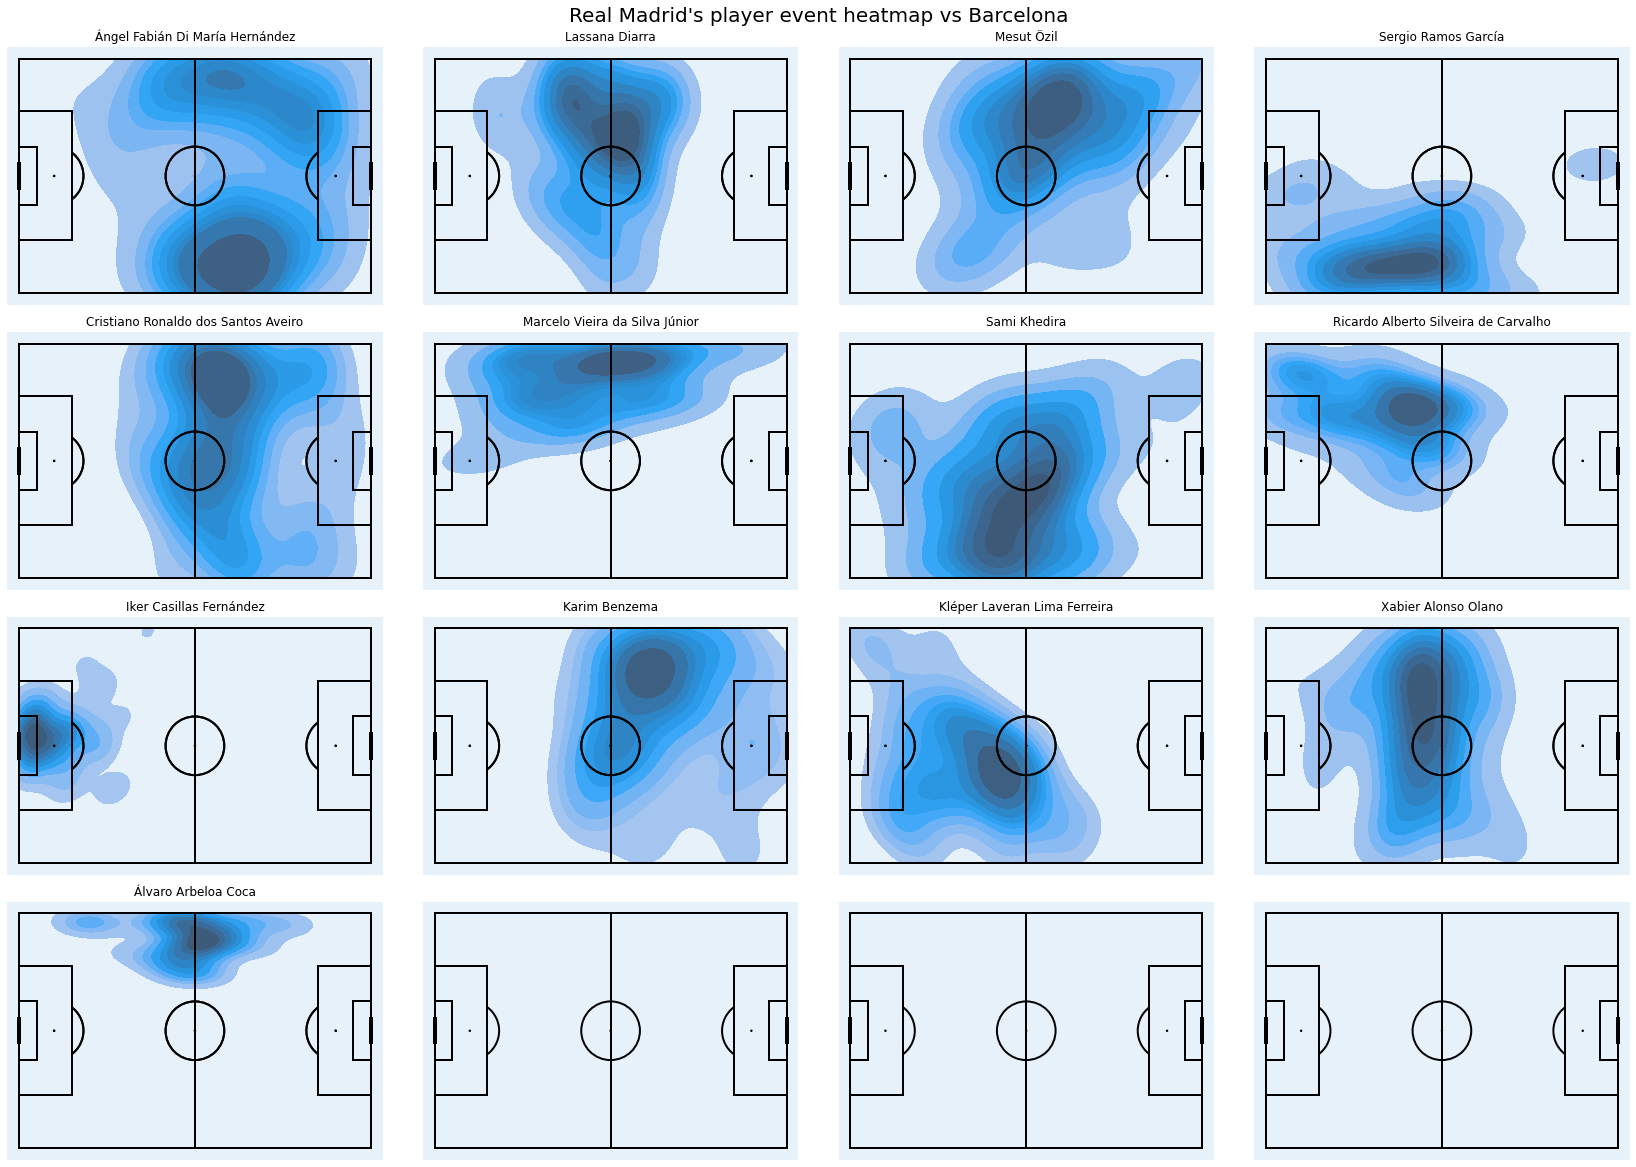

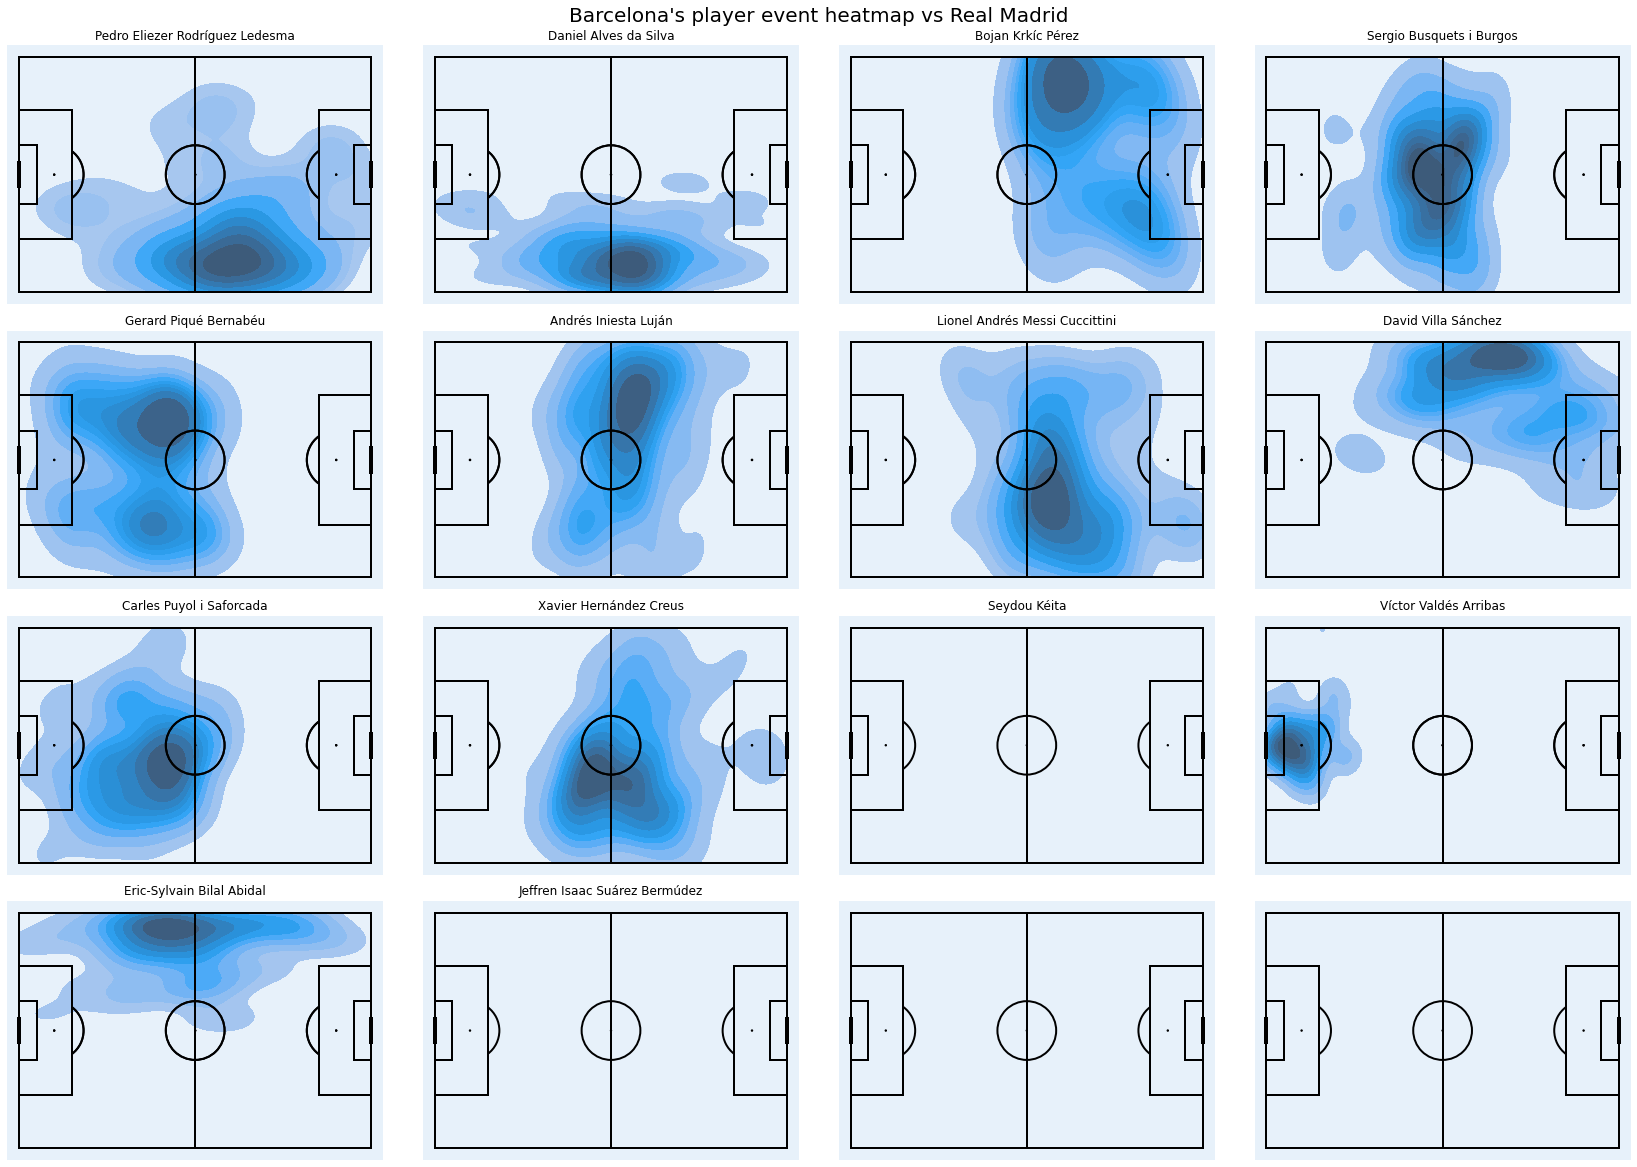

In [ ]:
for team_name, against_team_name in list(itertools.permutations([home_team.name, away_team.name])):
    # 選手数で可視化するグラフのレイアウトを決定
    n_players = len(lineups_df[lineups_df.team_name==team_name])
    n_cols = 4
    n_rows = math.ceil(n_players / n_cols)

    # 選手数だけピッチを作成
    pitch = Pitch(pitch_color='#e7f1fa', figsize=(n_cols*6, n_rows*4), layout=(n_rows, n_cols), line_zorder=2, line_color='black', pitch_type="statsbomb")
    fig, axes = pitch.draw()

    # 選手ごとのヒートマップを作成
    for i, (player_id, player_name) in enumerate(lineups_df[lineups_df.team_name==team_name][['player_id', 'player_name']].values):
        df_tmp = df[df.player_id==player_id][['coordinates_x', 'coordinates_y']].dropna().copy()
        ax = axes[math.floor(i/n_cols), i%n_cols]
        if len(df_tmp) > 20:
            pitch.draw(ax)
            pitch.kdeplot(
                df_tmp['coordinates_x'],
                df_tmp['coordinates_y'],
                ax=ax,
                shade=True,
                n_levels=10,
            )
        
        # タイトルの付与
        ax.set_title(player_name)
    # タイトルの付与
    fig.suptitle(f'{team_name}\'s player event heatmap vs {against_team_name}', y=1.01, fontsize=20)

## チームごとにプレッシャーをかけた位置のヒートマップを可視化

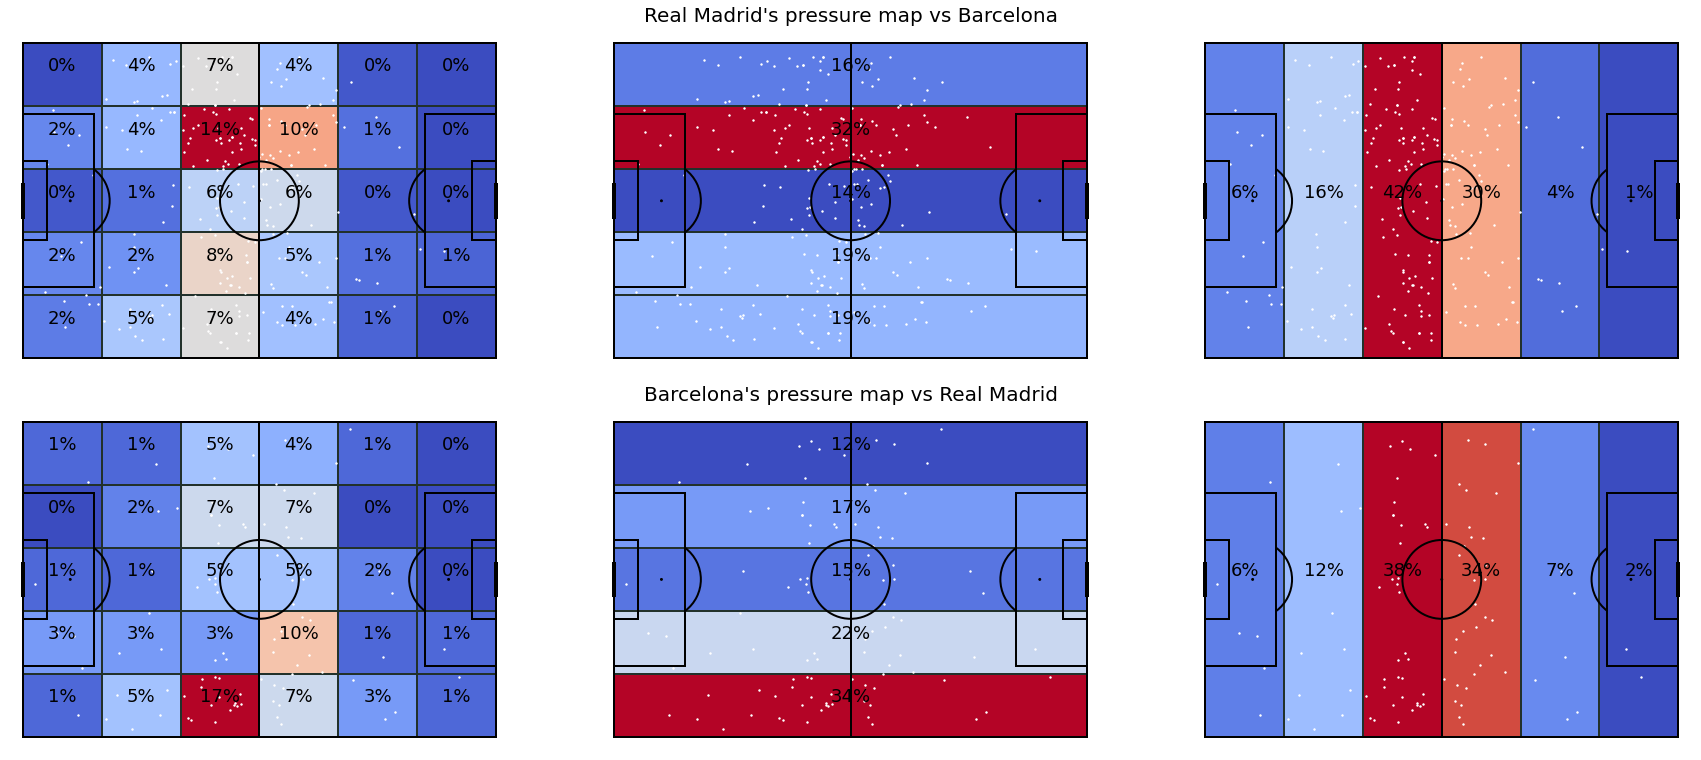

In [ ]:
pitch = Pitch(pitch_type='statsbomb', figsize=(9*3, 16/3*2), layout=(2, 3), line_zorder=2, line_color='black')

# draw
fig, axes = pitch.draw()
# heatmap specified by (nx, ny) for horizontal pitch
bins_list = [(6, 5), (1, 5), (6, 1)]
for i, (team_name, against_team_name) in enumerate(list(itertools.permutations([home_team.name, away_team.name]))):
    df_tmp = df[(df.event_type=='GENERIC:Pressure')&(df.team_name==team_name)]
    for j, bins in enumerate(bins_list):
        ax = axes[i, j]
        bin_statistic = pitch.bin_statistic(df_tmp['coordinates_x'], df_tmp['coordinates_y'], statistic='count', bins=bins)
        # draw
        pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', edgecolors='#22312b')
        pitch.scatter(df_tmp['coordinates_x'], df_tmp['coordinates_y'], c='white', s=2, ax=ax)
        # replace raw counts with percentages and add percentage sign (note immutable named tuple so used _replace)
        bin_statistic['statistic'] = (pd.DataFrame((bin_statistic['statistic'] / bin_statistic['statistic'].sum()))
                                      .applymap(lambda x: '{:.0%}'.format(x))
                                      .values)
        pitch.label_heatmap(bin_statistic, color='black', fontsize=18, ax=ax, ha='center', va='bottom')
        
        if j==1:
            ax.set_title(f'{team_name}\'s pressure map vs {against_team_name}', fontsize=20)

## パスの流れ（pass-flow）の可視化

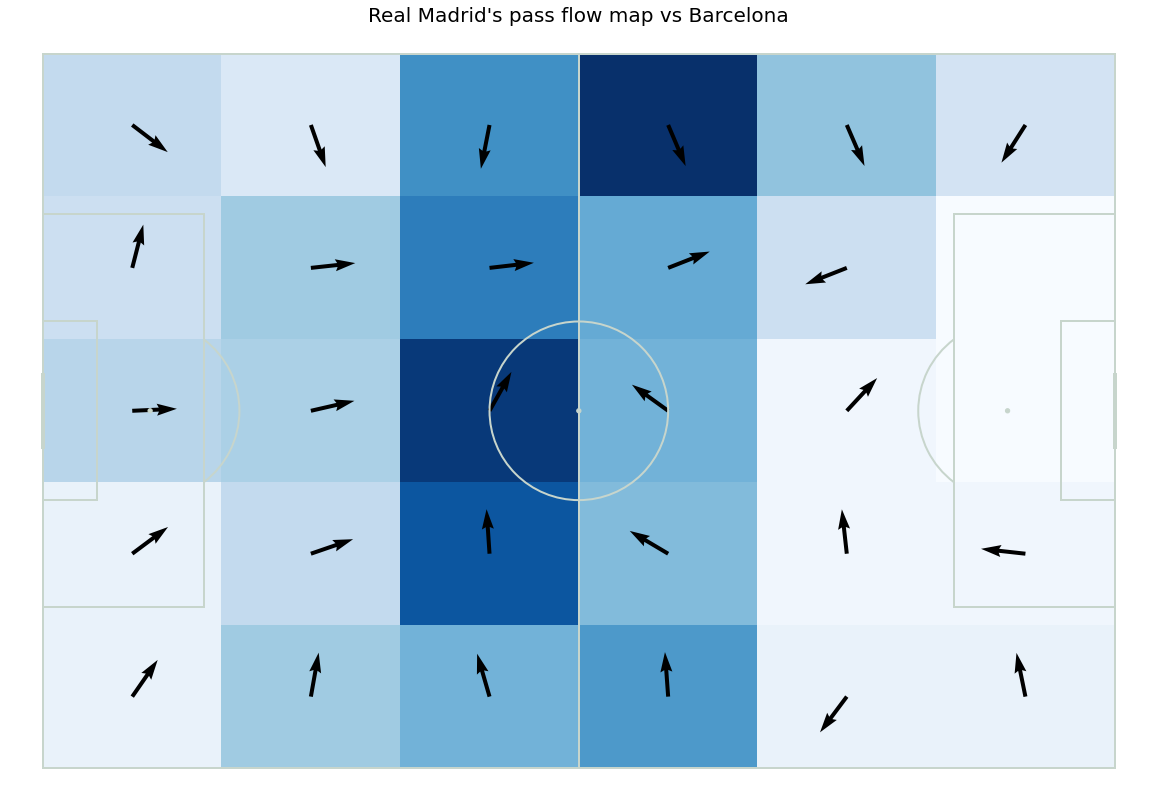

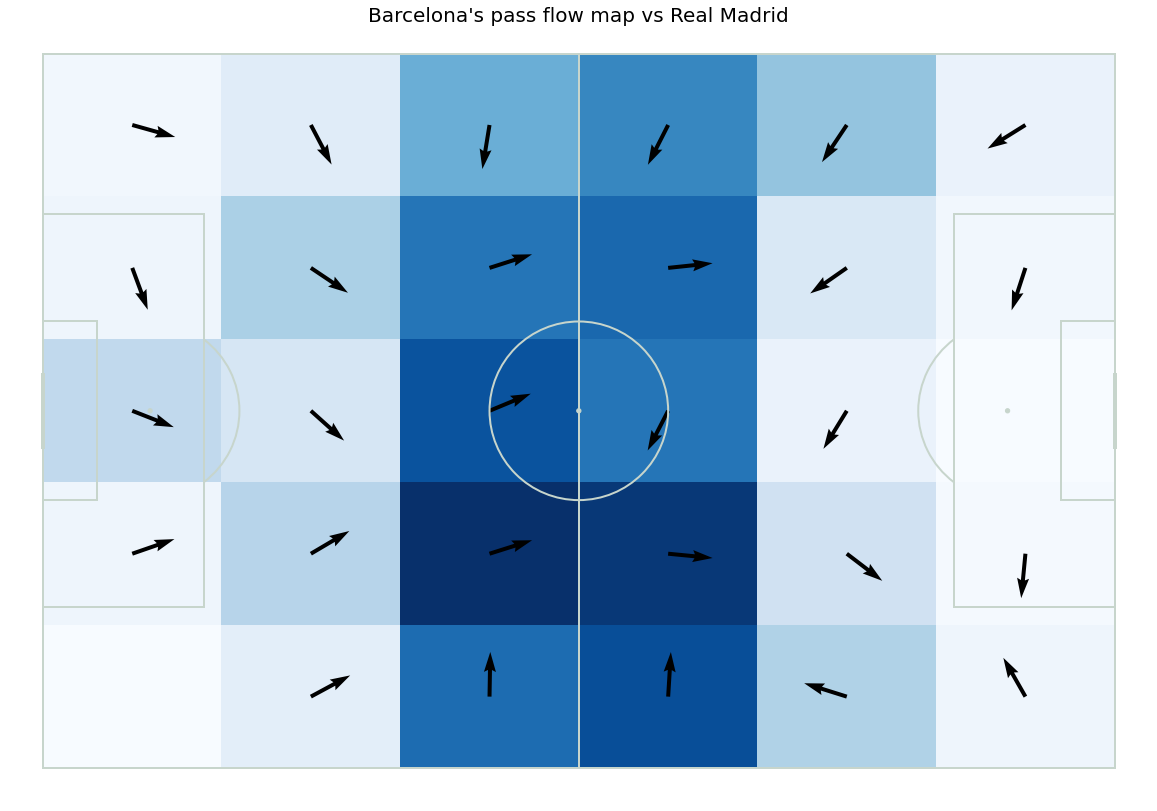

In [ ]:
for team_name, against_team_name in list(itertools.permutations([home_team.name, away_team.name])):
    df_tmp = df[(df.event_type=='PASS')&(df.team_name==team_name)][[c for c in df.columns.tolist() if c.endswith('_x') or c.endswith('_y')]].dropna().copy()

    pitch = Pitch(pitch_type='statsbomb', orientation='horizontal', figsize=(16, 11), line_zorder=2,
                line_color='#c7d5cc', constrained_layout=True, tight_layout=False)
    bins = (6, 5)

    fig, ax = pitch.draw()
    # plot the heatmap - darker colors = more passes originating from that square
    bs_heatmap = pitch.bin_statistic(df_tmp.coordinates_x, df_tmp.coordinates_y, statistic='count', bins=bins)
    hm = pitch.heatmap(bs_heatmap, ax=ax, cmap='Blues')
    # plot the pass flow map with a single color ('black') and length of the arrow (5)
    fm = pitch.flow(df_tmp.coordinates_x, df_tmp.coordinates_y, df_tmp.end_coordinates_x, df_tmp.end_coordinates_y, color='black', arrow_type='same',
                    arrow_length=5, bins=bins, ax=ax)
    fig.suptitle(f'{team_name}\'s pass flow map vs {against_team_name}', y=1.01, fontsize=20)

## より詳しい情報を持ったデータのダウンロード（イベント間の前後情報など）

In [ ]:
from mplsoccer.statsbomb import read_event, EVENT_SLUG
dataset_tmp = read_event(f'{EVENT_SLUG}/{match_id}.json', related_event_df=False, shot_freeze_frame_df=False)

players_df = dataset_tmp['tactics_lineup']
events_df = dataset_tmp['event']

events_df.loc[events_df.tactics_formation.notnull(), 'tactics_id'] = events_df.loc[events_df.tactics_formation.notnull(), 'id']
events_df[['tactics_id', 'tactics_formation']] = events_df.groupby('team_name')[['tactics_id', 'tactics_formation']].ffill()

## パスマップ図の可視化

In [ ]:
# 選手のポジション情報をサブ含めてまとめる
sub_players_df = events_df.loc[events_df.type_name == 'Substitution', ['tactics_id', 'player_id', 'substitution_replacement_id','substitution_replacement_name']]
sub_players_df = pd.merge(players_df, sub_players_df.rename({'tactics_id': 'id'}, axis='columns'), on=['id', 'player_id'], how='inner', validate='1:1')
sub_players_df = sub_players_df[['id', 'substitution_replacement_id', 'player_position_name']].rename({'substitution_replacement_id': 'player_id'}, axis='columns')
players_df = pd.concat([players_df, sub_players_df])
players_df.rename({'id': 'tactics_id'}, axis='columns', inplace=True)
players_df = players_df[['tactics_id', 'player_id', 'player_position_name']]

# 選手情報をイベントデータへ付与
events_df = events_df.merge(players_df, on=['tactics_id', 'player_id'], how='left', validate='m:1')
events_df = events_df.merge(players_df.rename({'player_id': 'pass_recipient_id'}, axis='columns'), on=['tactics_id', 'pass_recipient_id'], how='left', validate='m:1', suffixes=['', '_receipt'])

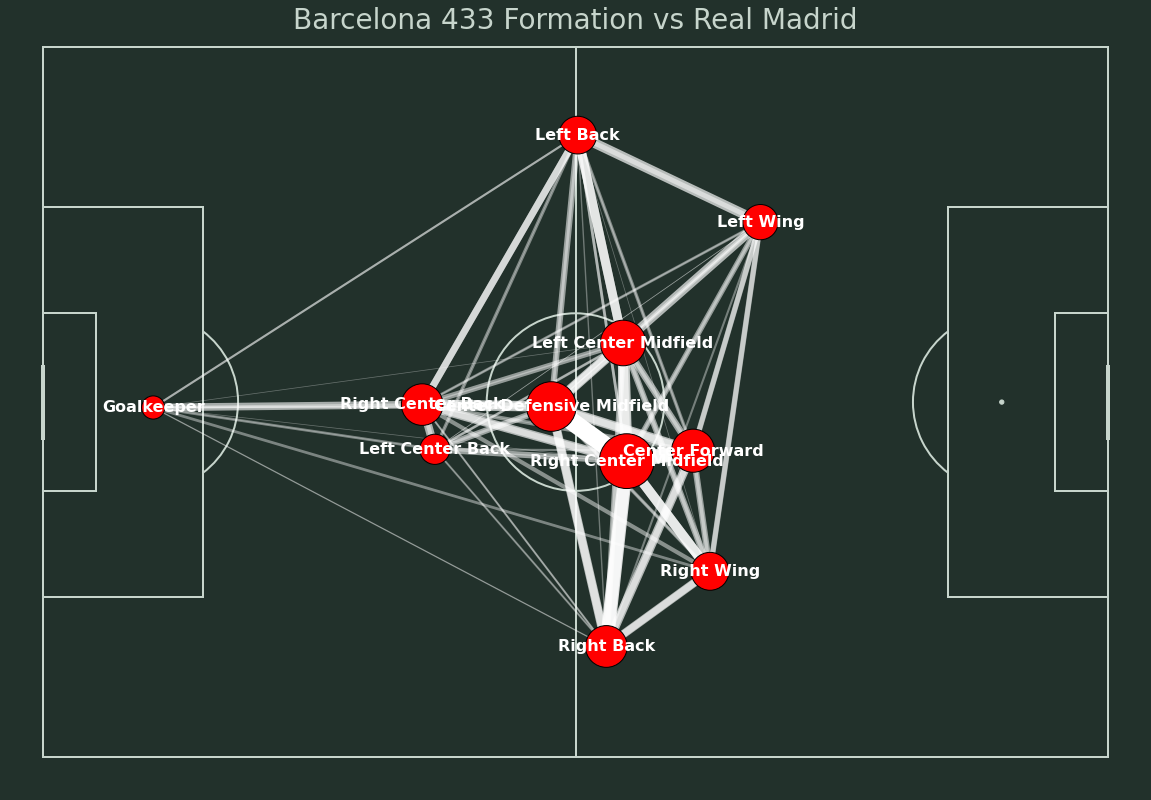

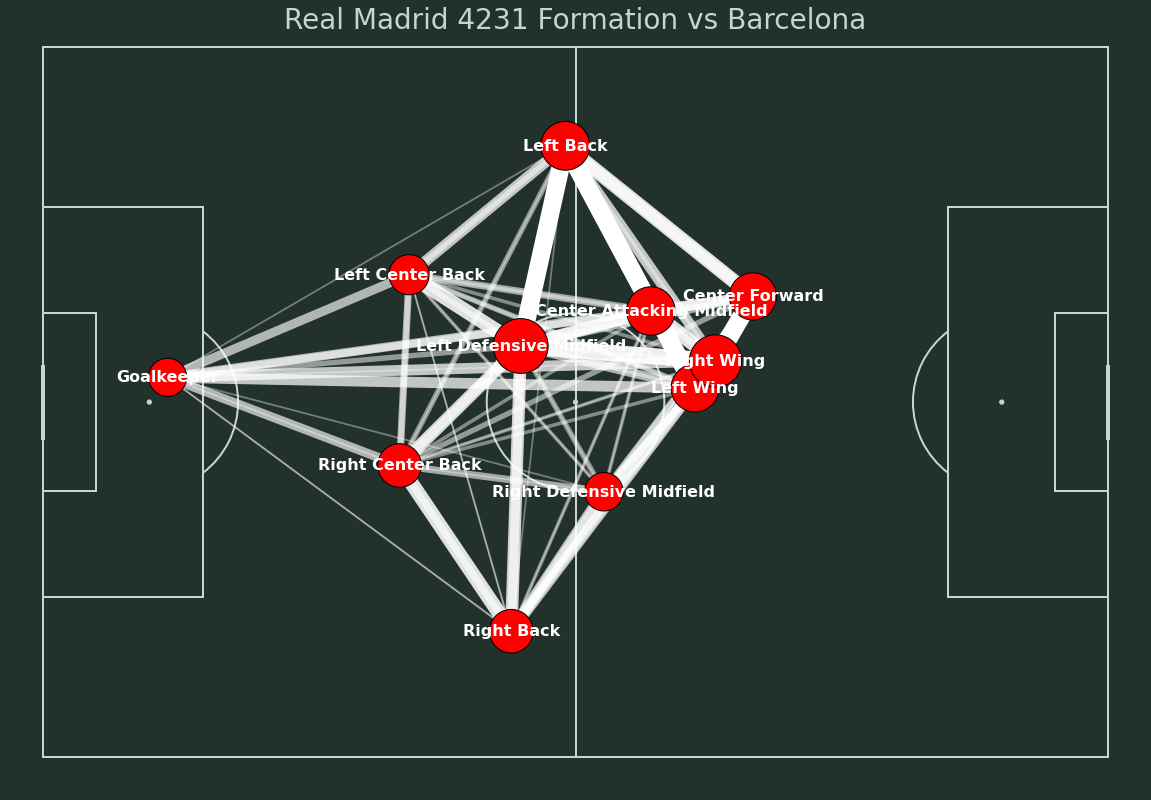

In [ ]:
from matplotlib.colors import to_rgba

for (team, against_team) in list(itertools.permutations(events_df[['team_name', 'tactics_formation']].drop_duplicates().values.tolist())):
    team_name, formation = team
    against_team_name = against_team[0]
    passes_formation = events_df.loc[(events_df.team_name == team_name) & (events_df.type_name == 'Pass') &
                                (events_df.tactics_formation == formation) &
                                (events_df.player_position_name.notnull()),
                                ['id', 'player_position_name', 'player_position_name_receipt']]

    location_formation = events_df.loc[(events_df.team_name == team_name) & (events_df.type_name.isin(['Pass', 'Ball Receipt'])) &
                                    (events_df.tactics_formation == formation),
                                    ['player_position_name', 'x', 'y']].dropna()

    # average locations
    average_locs_and_count = location_formation.groupby('player_position_name').agg({'x': ['mean'], 'y': ['mean', 'count']})
    average_locs_and_count.columns = ['x', 'y', 'count']

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_formation['pos_max'] = passes_formation[['player_position_name',
                                                    'player_position_name_receipt']].max(axis='columns')
    passes_formation['pos_min'] = passes_formation[['player_position_name',
                                                    'player_position_name_receipt']].min(axis='columns')
    passes_between = passes_formation.groupby(['player_position_name', 'player_position_name_receipt']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between = passes_between.merge(average_locs_and_count, left_on='player_position_name', right_index=True)
    passes_between = passes_between.merge(average_locs_and_count, left_on='player_position_name_receipt', right_index=True, suffixes=['', '_end'])

    # Calculate the line width and marker sizes relative to the largest counts
    max_line_width = 18
    max_marker_size = 3000
    passes_between['width'] = passes_between.pass_count / passes_between.pass_count.max() * max_line_width
    average_locs_and_count['marker_size'] = (average_locs_and_count['count'] / average_locs_and_count['count'].max() * max_marker_size)

    # Set color to make the lines more transparent when fewer passes are made
    min_transparency = 0.3
    color = np.array(to_rgba('white'))
    color = np.tile(color, (len(passes_between), 1))
    c_transparency = passes_between.pass_count / passes_between.pass_count.max()
    c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
    color[:, 3] = c_transparency

    # Plotting
    pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
                pitch_color='#22312b', line_color='#c7d5cc', figsize=(16, 11),
                constrained_layout=True, tight_layout=False)
    fig, ax = pitch.draw()
    pass_lines = pitch.lines(passes_between.x, passes_between.y,
                            passes_between.x_end, passes_between.y_end, lw=passes_between.width,
                            color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count.x, average_locs_and_count.y, s=average_locs_and_count.marker_size,
                            color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count.iterrows():
        pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center', ha='center', size=16, weight='bold', ax=ax)
    title = ax.set_title("{} {} Formation vs {}".format(team_name, int(formation), against_team_name), size=28, y=0.97, color='#c7d5cc')
    fig.set_facecolor("#22312b")    

## ショットマップの可視化

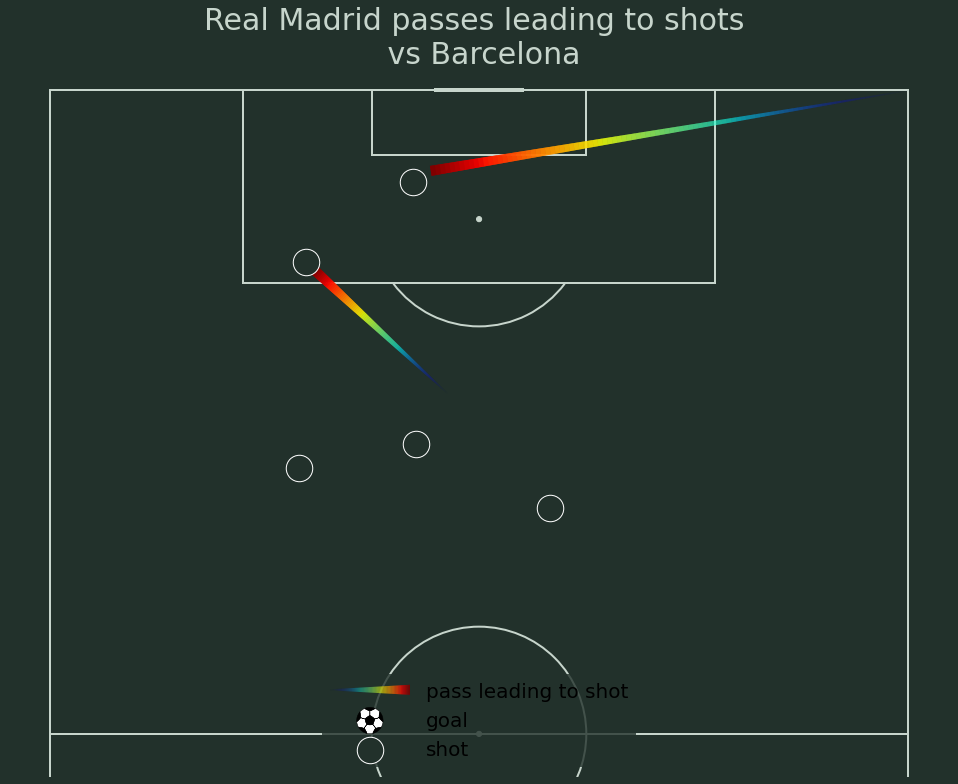

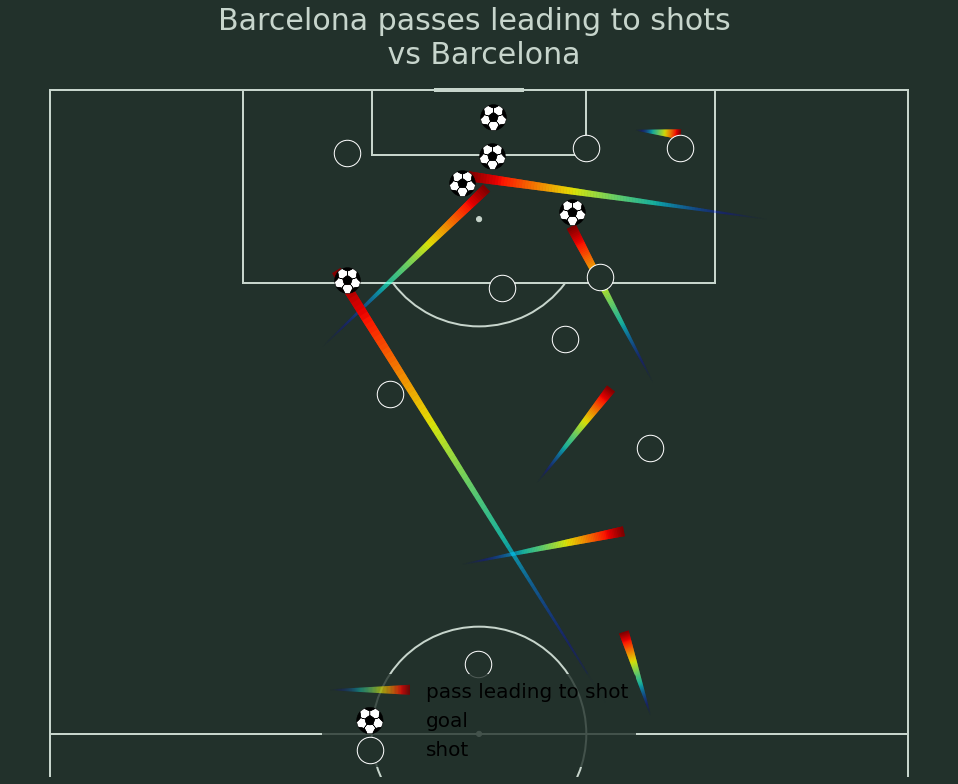

In [ ]:
# チームごとに
for (team_name, against_team) in list(itertools.permutations([home_team.name, away_team.name])):
    df_pass = events_df.loc[(events_df.pass_assisted_shot_id.notnull()) & (events_df.team_name == team_name),
                    ['x', 'y', 'end_x', 'end_y', 'pass_assisted_shot_id']]

    df_shot = events_df.loc[(events_df.type_name == 'Shot') & (events_df.team_name == team_name),
                    ['id', 'x', 'y' , 'outcome_name', 'shot_statsbomb_xg']].rename({'id': 'pass_assisted_shot_id'}, axis=1)

    df_pass = df_pass.merge(df_shot, how='left').drop('pass_assisted_shot_id', axis=1)

    mask_goal = df_pass.outcome_name == 'Goal'

    # ピットの作成
    pitch = Pitch(pitch_type='statsbomb', orientation='vertical', pitch_color='#22312b', line_color='#c7d5cc',
                figsize=(16, 11), view='half', pad_top=2, tight_layout=True)
    fig, ax = pitch.draw()

    # シュートにつながったパスのlineを可視化
    pitch.lines(df_pass.x, df_pass.y, df_pass.end_x, df_pass.end_y,
                lw=10, transparent=True, comet=True, cmap='jet',
                label='pass leading to shot', ax=ax)

    # ゴールの可視化
    pitch.scatter(df_shot[df_shot.outcome_name=='Goal'].x, df_shot[df_shot.outcome_name=='Goal'].y, s=700,
                marker='football', edgecolors='black', c='white', zorder=2,
                label='goal', ax=ax)
    pitch.scatter(df_shot[df_shot.outcome_name!='Goal'].x, df_shot[df_shot.outcome_name!='Goal'].y,
                edgecolors='white', c='#22312b', s=700, zorder=2,
                label='shot', ax=ax)
    # タイトルの付与
    ax.set_title(f'{team_name} passes leading to shots \n vs {against_team_name}', fontsize=30, color='#c7d5cc')

    # 判例の付与
    ax.legend(facecolor='#22312b', edgecolor='None', fontsize=20, loc='lower center', handlelength=4)

    # 背景色の設定
    fig.set_facecolor('#22312b')